In [415]:
import matplotlib.pyplot as plt
import os
path="train/"
folders=os.listdir(path)
# from datetime import datetime
import numpy as np

# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)

lable_list=[] # save the emotion lable  [0 'angry', 1'disgust', 2'fear', 3'happy', 4'neutral', 5'sad', 6'surprise']
imgs=[] #save the imamges

for i in range(len(folders)):
    path_emotion=path+folders[i]
    filenames=sorted(os.listdir(path_emotion))      
    #print("..................")
    #print(filenames)
    for j in range(len(filenames)):
        lable_list.append(i)
        img=plt.imread(path_emotion+"/"+filenames[j])
        imgs.append(img)
print("train/angry number: ",lable_list.count(0))
print("train/disgust number: ",lable_list.count(1))
print("train/fear number: ",lable_list.count(2))
print("train/happy number: ",lable_list.count(3))
print("train/neutral number: ",lable_list.count(4))
print("train/sad number: ",lable_list.count(5))
print("train/surprise number: ",lable_list.count(6))

train/angry number:  3171
train/disgust number:  3995
train/fear number:  4830
train/happy number:  7215
train/neutral number:  436
train/sad number:  4097
train/surprise number:  4965


In [416]:

lable_np=np.array(lable_list)
imgs_np=np.array(imgs)
print(imgs_np.shape, "\n" , lable_np.shape)




(28709, 48, 48) 
 (28709,)


In [417]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(imgs_np, lable_np, stratify=lable_np, test_size=0.7, random_state=42)


In [418]:
print('x_train_shape',X_train.shape)
print('X_test_shape',X_test.shape)
print('y_train_shape',y_train.shape)
print('y_test_shape',y_test.shape)

x_train_shape (8612, 48, 48)
X_test_shape (20097, 48, 48)
y_train_shape (8612,)
y_test_shape (20097,)


In [419]:
# LBP calculation
import skimage.feature
numpoints_lbp = 25
radius_lbp = 5
lbp_method = 'uniform'

X_train_lbp = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    X_train_lbp[i,:,:] = skimage.feature.local_binary_pattern(X_train[i,:,:], numpoints_lbp,radius_lbp,method=lbp_method)

print(X_train_lbp.shape)

(8612, 48, 48)


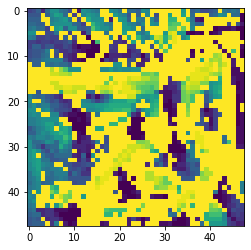

In [420]:
plt.imshow(X_train_lbp[5,:,:])
plt.show()


In [421]:
# partition image into 4*4 regions 
# then calculate 16 historgram , 10 bins in historgramme for each region (10 * 16)
N = 4
n_bins = 10

X_lbp_hist_16_counts = np.zeros([X_train.shape[0], N*N , n_bins ])
X_lbp_hist_16_bins = np.zeros([X_train.shape[0], N*N , n_bins + 1 ])
for i in range(X_train.shape[0]):
    X_lbp = X_train_lbp[i,:,:]
    for j in range(X_lbp_hist_16.shape[1]) :
        ii = np.floor(j/N)
        jj = j%N
        h1 = int( ii*(48/N) )
        h2 = int( (ii+1)*(48/N) )
        w1 = int( jj*(48/N) )
        w2 = int( (jj+1)*(48/N) )
        counts, bins = np.histogram(X_lbp[ h1 : h2 ,  w1 : w2].flatten(), bins=n_bins, range=(0,9))
        X_lbp_hist_16_counts[i,j,:] = counts
        X_lbp_hist_16_bins[i,j,:] = bins

print(X_lbp_hist_16_bins.shape)

print(X_lbp_hist_16_counts.shape)

(8612, 16, 11)
(8612, 16, 10)


In [422]:
# Function calculate the 16 histogrammes for one image


def NN_histogram(img_lbp,N,n_bins):
    X_lbp_histNN_counts = np.zeros([N*N , n_bins ])
    X_lbp_histNN_bins = np.zeros([N*N , n_bins+1 ])
    for j in range(N*N) :
        ii = np.floor(j/N)
        jj = j%N
        h1 = int( ii*(48/N) )
        h2 = int( (ii+1)*(48/N) )
        w1 = int( jj*(48/N) )
        w2 = int( (jj+1)*(48/N) )
        counts, bins = np.histogram(img_lbp[ h1 : h2 ,  w1 : w2].flatten(), bins=n_bins, range=(0,9))
        X_lbp_histNN_counts[j,:] = counts
        X_lbp_histNN_bins[j,:] = bins
    return X_lbp_histNN_counts , X_lbp_histNN_bins



(10,)


(array([5., 3., 3., 5., 6., 4., 1., 0., 2., 7.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

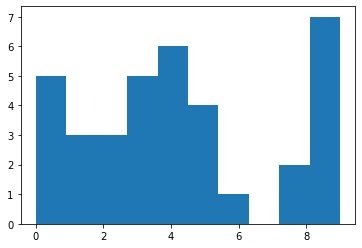

In [423]:
# example usage NN_histogram(img_lbp,N,n_bins):
N = 4
n_bins = 10
X_lbp = X_train_lbp[2,:,:]

counts, bins = NN_histogram(X_lbp,N,n_bins)

region = 5
X_lbp_histNN_counts = counts[region,:]
X_lbp_histNN_bins = bins[region,:]
print(X_lbp_histNN_counts.shape)

plt.hist(X_lbp_histNN_bins[:-1], X_lbp_histNN_bins, weights=X_lbp_histNN_counts)

In [424]:
#flatten the histogram result  (8612, 16, 10) -> (8612, 160)
X_lbp_hist_16_counts_160 = X_lbp_hist_16_counts.reshape([X_lbp_hist_16_counts.shape[0],X_lbp_hist_16_counts.shape[1] * X_lbp_hist_16_counts.shape[2]])
print(X_lbp_hist_16_counts_160.shape)

(8612, 160)


In [425]:
# train the KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights = 'distance' , p=2, metric='minkowski')#, metric='euclidean')
neigh.fit(X_lbp_hist_16_counts_160, y_train)

KNeighborsClassifier(weights='distance')

In [385]:
#img_flat[np.isnan(img_flat)] = 0
#img_flat[np.isinf(img_flat)] = 255

In [426]:
#test

#for each category
for cat in range(7):
    img_cat = X_test[y_test == cat,:,:]
    #for all images in cat
    counter = 0
    for i in range(img_cat.shape[0]):
        img_test = img_cat[i,:,:]
        img_test_lbp = skimage.feature.local_binary_pattern(img_test, numpoints_lbp,radius_lbp,method=lbp_method)
        X_test_histNN_counts , X_test_histNN_bins =  NN_histogram(img_test_lbp,N,n_bins)
        X_test_histNN_counts = X_test_histNN_counts.flatten()
        #prediction
        if neigh.predict(np.array([X_test_histNN_counts.flatten()])) == cat :
            counter += 1
    print("accuracy for category " , cat , " is " , 100* counter/img_cat.shape[0] , "% \n")
            


accuracy for category  0  is  36.351351351351354 % 

accuracy for category  1  is  23.49785407725322 % 

accuracy for category  2  is  18.75184856551316 % 

accuracy for category  3  is  35.93347851910513 % 

accuracy for category  4  is  17.049180327868854 % 

accuracy for category  5  is  25.0 % 

accuracy for category  6  is  21.403912543153048 % 



In [114]:
# exemple image with historgramme on one region/16

#category
cat = 3
img_cat = X_test[y_test == cat,:,:]

rand = int(np.floor(np.random.uniform(0,1) * 100))
#take one img
img_test = img_cat[rand,:,:]
plt.imshow(img_test)

#calculate lbp
img_test_lbp = skimage.feature.local_binary_pattern(img_test, 30,6,method='uniform')

#4*4 roi histogramme
N = 4
n_bins = 10
X_test_histNN_counts , X_test_histNN_bins =  NN_histogram(img_test_lbp,N,n_bins)
#X_test_histNN_counts = X_test_histNN_counts.flatten()


region = 10
X_test_histNN_counts_roi = X_test_histNN_counts[region,:]
X_test_histNN_bins_roi = X_test_histNN_bins[region,:]
plt.figure()
plt.hist(X_test_histNN_bins_roi[:-1], X_test_histNN_bins_roi, weights=X_test_histNN_counts_roi)


X_test_histNN_counts = X_test_histNN_counts.flatten()
print(neigh.predict(np.array([X_test_histNN_counts])) == 3)